In [382]:
# Metabook pg. 98
# Using A3 for constants

import numpy as math
import matplotlib.pyplot as plt

W_P = 19.5
W_S = 12.2
W_initial = 6409
P_initial = W_initial / W_P
S_initial = W_initial / W_S
W0 = 10000
A = 0.74  # Regression constants from Martin's Metabook which cites it from Raymer (2006, Table 3.1)
C = -0.03

c_sl = 0.2 * 32.17 # specific fuel consumtion factor in lb / hp-hr # float(input("Enter the value of c_SL: "))  # Algorithm 3 pg. 50 Metabook
S_wet_initial = 1458
S_wet_initial_rest = S_wet_initial - (2*56*6)
weight_crew = 180
weight_payload = 2000

V = 250 * 1.688
weight_tol = 1e-6
rho = 0.00238
cL_max_takeoff = 1.7 # CHECK #float(input("Enter the cL_max of the wing: ")) #Needs to be approximated based on historical data
cL_max_cruise = 1.6 # CHECK
cL_max_landing = 1.8 # CHECK
V_stall = 52 * 1.688# ft/s approximation - stall speed of a small aircraft # math.sqrt((2 * W_0) / (rho * S_ref * cL_max)) #float(input("Enter the stall velocity (ft/s): "))

s_to = 1500 # RFP #float(input("Enter the takeoff distance (ft): "))
a = 0.0149 
b = 8.134 
discriminant = b**2 - 4*a*(-s_to)
top23 = (-b + math.sqrt(discriminant)) / (2*a)
rho_condition = 0.0023672

s_a = 600 # ft - from Raymer's text pg. 138
s_landing = 1500 # in ft

eta_p = 0.95
c = 1.0447 # Source - Gama
d = 0.5326 # Source - Gama
c_f = 0.0055 # figure 4.4 on Metabook - "light aircraft - single engine"
G3 = 0.083
V_climb = V_stall * 1.1
q_climb = 0.5 * rho * (V_climb)**2
eff_clean = 0.825

V_balked = V_stall * 1.15
q_baled = 0.5 * rho * (V_balked)**2
G1 = 0.03

n = 2 # float(input("Enter the load factor (#g): "))
V_mn = V * 0.5
q_maneuver = 0.5 * rho_condition * V_mn**2

v_cruise = V * 0.5
q_cruise = 0.5 * rho_condition * v_cruise**2

V_ceiling = V * 0.5
Gceiling = (100 / 60) / V_ceiling
q_ceiling = 0.5 * rho * (V_ceiling)**2

def stall_WS():
    WS_stall = (1/2) * (rho) * (V_stall)**2 * cL_max_landing
    return WS_stall

def landing_WS():
    WS_landing = ( (s_landing - s_a) / 80 ) * ((rho_condition / rho) * cL_max_landing)
    return WS_landing

def takeoff(WS): 
    power_weight_ratio_takeoff = WS / ((rho_condition / rho) * cL_max_takeoff * top23)
    return power_weight_ratio_takeoff

def climb(WS, cd_0, AR):
    power_weight_ratio_climb2 = ((V_climb/eta_p) * (G3 + ((q_climb * cd_0 / WS) + (WS / (AR * math.pi * eff_clean * q_climb))))) / 550
    power_weight_ratio_climb_takeoff2 = power_weight_ratio_climb2 / 0.8
    return power_weight_ratio_climb_takeoff2

def balked_climb(WS, cd_0, AR):
    power_weight_ratio_climb4 = ((V_balked/eta_p) * (G1 + ((q_baled * cd_0 / WS) + (WS / (AR * math.pi * eff_clean * q_baled))))) / 550
    power_weight_ratio_climb_takeoff4 = power_weight_ratio_climb4 / 0.8
    return power_weight_ratio_climb_takeoff4

def maneuver(WS, cd_0, AR):
    power_weight_ratio_maneuver2 = ((V_mn/eta_p) * ((q_maneuver * cd_0 / WS) + (WS * (n**2) / (AR * math.pi * eff_clean * q_maneuver)))) / 550
    return power_weight_ratio_maneuver2

def cruise(WS, cd_0, AR):
    power_weight_ratio_cruise = ((q_cruise * v_cruise * (cd_0 + ((WS**2)*(0.956**2) / ((q_cruise**2) * math.pi * AR * eff_clean)))) / (550 * eta_p * WS)) / 0.75 # metabook pg. 43
    return power_weight_ratio_cruise

def ceiling(WS, cd_0, AR):
    power_weight_ratio_ceiling2 = ((V_ceiling/eta_p) * (Gceiling + ((q_ceiling * cd_0 / WS) + (WS / (AR * math.pi * eff_clean * q_ceiling))))) / 550
    return power_weight_ratio_ceiling2

S_range = math.linspace(1, 801, 201)
P_range = math.linspace(1, 1001, 201)
S_ST = math.ones(201)
S_LD = math.ones(201)
P_TO = math.ones(201)
P_CL = math.ones(201)
P_BC = math.ones(201)
P_MN = math.ones(201)
P_CR = math.ones(201)
P_CE = math.ones(201)

stall_con = math.ones(201)
landing_con = math.ones(201)
takeoff_con = math.ones(201)
climb_con = math.ones(201)
balked_climb_con = math.ones(201)
maneuver_con = math.ones(201)
cruise_con = math.ones(201)
ceiling_con = math.ones(201)

#balked_climb_con[i] = balked_climb(W0_S0, parasite_drag_coeff, AR_iter) * W0
#maneuver_con[i] = maneuver(W0_S0, parasite_drag_coeff, AR_iter) * W0
#cruise_con[i] = cruise(W0_S0, parasite_drag_coeff, AR_iter) * W0
#ceiling_con[i] = ceiling(W0_S0, parasite_drag_coeff, AR_iter) * W0

In [383]:
for i in range(201):
    S0 = S_range[i]
    P_TO[i] = P_initial
    tolerance = 0.1
    converged = False
    tol = 2e-6
    while converged == False:
        W0 = 6409
        while tol > weight_tol:
            We_W0 = A * ((W0**C))
            We = We_W0 * W0
            density_wing = 2.5  # lb/ft^2 Metabook pg. 76
            We += density_wing * (S0 - S_initial)
            W_engine_dp = (P_initial ** 0.9306) * (10 ** -0.1205) # Metabook 79
            W_engine = (P_TO[i] ** 0.9306) * (10 ** -0.1205)
            We += (W_engine) - (W_engine_dp)

            # Algorithm 3 - fuel fraction calculation
            T_inital = P_initial * 550 / (125*1.688)
            W1_W0 = 1 - c_sl * (15 / 60) * (0.05 * T_inital / W0)  # fuel burned from running the engine for 15 min at 5% max
            W1 = W1_W0 * W0
            W2_W1 = 1 - c_sl * (1 / 60) * (T_inital / W1)  # Fuel burned from running the engine for 1 min at max
            W3_W2 = 0.998  # climb segment in Algorithm 3 - using historical values

            c_f = 0.0055 # figure 4.4 on Metabook - "light aircraft - single engine"
            eff_clean = 0.825  # Oswald efficiency factor
            AR = (56**2)/S0  # Aspect ratio NEEDS TO CHANGE FOR CHANGE OF AIRCRAFT

            CD_0 = c_f * (S_wet_initial_rest + (2 * S0)) / S0  # Zero-lift drag coefficient
            k = 1 / (math.pi * eff_clean * AR)  # Induced drag factor
            CL = math.sqrt(CD_0 / k)  # Optimal CL for max L/D (Fix applied)
            L_D = (0.94 * CL) / (CD_0 + k * CL**2)  # Lift-to-drag ratio

            W4_W3 = math.exp(-(600 * 1.151) * c_sl / (125 * 1.688 * 3600 * L_D / 5280))  # weight fraction during cruising

            W5_W4 = 0.999  # Descent historical value
            W6_W5 = 0.998  # Landing historical value

            W6_W0 = W6_W5 * W5_W4 * W4_W3 * W3_W2 * W2_W1 * W1_W0
            Wf_W0 = 1 - W6_W0

            W0_new = (weight_crew + weight_payload) / (1 - Wf_W0 - We/W0)  # calculating the new takeoff gross weight
            tol = abs(W0_new - W0) / abs(W0_new)  # finding the difference between the last and current iteration of W0
            W0 = W0_new  # updating the takeoff gross weight
        W0_S0 = W0 / S0
        S_wet = (10 ** c) * (W0 ** d)# 4605 * 142.45 # float(input("Enter the reference wing wet area (ft^2): "))
        S_wet_S_ref =  S_wet / S0 # 4 - from Raymer's text
        parasite_drag_coeff = c_f * S_wet_S_ref
        takeoff_con[i] = takeoff(W0_S0) * W0
        if abs(takeoff_con[i] - P_TO[i]) <= tolerance:
            converged = True
        P_TO[i] = takeoff_con[i]


/var/folders/_m/6r3r9r4d1cs6rbs568htxt040000gn/T/ipykernel_13553/854261262.py:10: RuntimeWarning: invalid value encountered in scalar power
  We_W0 = A * ((W0**C))


In [384]:
for i in range(201):
    S0 = S_range[i]
    P_CL[i] = P_initial
    tolerance = 0.1
    converged = False
    tol = 2e-6
    while converged == False:
        W0 = 6409
        while tol > weight_tol:
            We_W0 = A * (W0 ** C)  # formula for empty weight ratio - based on the current W0
            We = We_W0 * W0
            density_wing = 2.5  # lb/ft^2 Metabook pg. 76
            We += density_wing * (S0 - S_initial)
            W_engine_dp = (P_initial ** 0.9306) * (10 ** -0.1205) # Metabook 79
            W_engine = (P_CL[i] ** 0.9306) * (10 ** -0.1205)
            We += (W_engine) - (W_engine_dp)

            # Algorithm 3 - fuel fraction calculation
            T_inital = P_initial * 550 / (125*1.688)
            W1_W0 = 1 - c_sl * (15 / 60) * (0.05 * T_inital / W0)  # fuel burned from running the engine for 15 min at 5% max
            W1 = W1_W0 * W0
            W2_W1 = 1 - c_sl * (1 / 60) * (T_inital / W1)  # Fuel burned from running the engine for 1 min at max
            W3_W2 = 0.998  # climb segment in Algorithm 3 - using historical values

            c_f = 0.0055 # figure 4.4 on Metabook - "light aircraft - single engine"
            eff_clean = 0.825  # Oswald efficiency factor
            AR = (56**2)/S0  # Aspect ratio NEEDS TO CHANGE FOR CHANGE OF AIRCRAFT

            CD_0 = c_f * (S_wet_initial_rest + (2 * S0)) / S0  # Zero-lift drag coefficient
            k = 1 / (math.pi * eff_clean * AR)  # Induced drag factor
            CL = math.sqrt(CD_0 / k)  # Optimal CL for max L/D (Fix applied)
            L_D = (0.94 * CL) / (CD_0 + k * CL**2)  # Lift-to-drag ratio

            W4_W3 = math.exp(-(600 * 1.151) * c_sl / (125 * 1.688 * 3600 * L_D / 5280))  # weight fraction during cruising

            W5_W4 = 0.999  # Descent historical value
            W6_W5 = 0.998  # Landing historical value

            W6_W0 = W6_W5 * W5_W4 * W4_W3 * W3_W2 * W2_W1 * W1_W0
            Wf_W0 = 1 - W6_W0

            W0_new = (weight_crew + weight_payload) / (1 - Wf_W0 - We/W0)  # calculating the new takeoff gross weight
            tol = abs(W0_new - W0) / abs(W0_new)  # finding the difference between the last and current iteration of W0
            W0 = W0_new  # updating the takeoff gross weight
        W0_S0 = W0 / S0
        S_wet = (10 ** c) * (W0 ** d)# 4605 * 142.45 # float(input("Enter the reference wing wet area (ft^2): "))
        S_wet_S_ref =  S_wet / S0 # 4 - from Raymer's text
        parasite_drag_coeff = c_f * S_wet_S_ref
        climb_con[i] = climb(W0_S0, parasite_drag_coeff, 28/3) * W0
        if abs(climb_con[i] - P_CL[i]) <= tolerance:
            converged = True
        P_CL[i] = climb_con[i]

/var/folders/_m/6r3r9r4d1cs6rbs568htxt040000gn/T/ipykernel_13553/3187281731.py:10: RuntimeWarning: invalid value encountered in scalar power
  We_W0 = A * (W0 ** C)  # formula for empty weight ratio - based on the current W0


In [385]:
for i in range(201):
    S0 = S_range[i]
    P_BC[i] = P_initial
    tolerance = 0.1
    converged = False
    tol = 2e-6
    while converged == False:
        W0 = 6409
        while tol > weight_tol:
            We_W0 = A * (W0 ** C)  # formula for empty weight ratio - based on the current W0
            We = We_W0 * W0
            density_wing = 2.5  # lb/ft^2 Metabook pg. 76
            We += density_wing * (S0 - S_initial)
            W_engine_dp = (P_initial ** 0.9306) * (10 ** -0.1205) # Metabook 79
            W_engine = (P_BC[i] ** 0.9306) * (10 ** -0.1205)
            We += (W_engine) - (W_engine_dp)

            # Algorithm 3 - fuel fraction calculation
            T_inital = P_initial * 550 / (125*1.688)
            W1_W0 = 1 - c_sl * (15 / 60) * (0.05 * T_inital / W0)  # fuel burned from running the engine for 15 min at 5% max
            W1 = W1_W0 * W0
            W2_W1 = 1 - c_sl * (1 / 60) * (T_inital / W1)  # Fuel burned from running the engine for 1 min at max
            W3_W2 = 0.998  # climb segment in Algorithm 3 - using historical values

            c_f = 0.0055 # figure 4.4 on Metabook - "light aircraft - single engine"
            eff_clean = 0.825  # Oswald efficiency factor
            AR = (56**2)/S0  # Aspect ratio NEEDS TO CHANGE FOR CHANGE OF AIRCRAFT

            CD_0 = c_f * (S_wet_initial_rest + (2 * S0)) / S0  # Zero-lift drag coefficient
            k = 1 / (math.pi * eff_clean * AR)  # Induced drag factor
            CL = math.sqrt(CD_0 / k)  # Optimal CL for max L/D (Fix applied)
            L_D = (0.94 * CL) / (CD_0 + k * CL**2)  # Lift-to-drag ratio

            W4_W3 = math.exp(-(600 * 1.151) * c_sl / (125 * 1.688 * 3600 * L_D / 5280))  # weight fraction during cruising

            W5_W4 = 0.999  # Descent historical value
            W6_W5 = 0.998  # Landing historical value

            W6_W0 = W6_W5 * W5_W4 * W4_W3 * W3_W2 * W2_W1 * W1_W0
            Wf_W0 = 1 - W6_W0

            W0_new = (weight_crew + weight_payload) / (1 - Wf_W0 - We/W0)  # calculating the new takeoff gross weight
            tol = abs(W0_new - W0) / abs(W0_new)  # finding the difference between the last and current iteration of W0
            W0 = W0_new  # updating the takeoff gross weight
        W0_S0 = W0 / S0
        S_wet = (10 ** c) * (W0 ** d)# 4605 * 142.45 # float(input("Enter the reference wing wet area (ft^2): "))
        S_wet_S_ref =  S_wet / S0 # 4 - from Raymer's text
        parasite_drag_coeff = c_f * S_wet_S_ref
        balked_climb_con[i] = balked_climb(W0_S0, parasite_drag_coeff, 28/3) * W0
        if abs(balked_climb_con[i] - P_BC[i]) <= tolerance:
            converged = True
        P_BC[i] = balked_climb_con[i]

/var/folders/_m/6r3r9r4d1cs6rbs568htxt040000gn/T/ipykernel_13553/3971712021.py:10: RuntimeWarning: invalid value encountered in scalar power
  We_W0 = A * (W0 ** C)  # formula for empty weight ratio - based on the current W0


In [386]:
for i in range(201):
    S0 = S_range[i]
    P_MN[i] = P_initial
    tolerance = 0.1
    converged = False
    tol = 2e-6
    while converged == False:
        W0 = 6409
        while tol > weight_tol:
            We_W0 = A * (W0 ** C)  # formula for empty weight ratio - based on the current W0
            We = We_W0 * W0
            density_wing = 2.5  # lb/ft^2 Metabook pg. 76
            We += density_wing * (S0 - S_initial)
            W_engine_dp = (P_initial ** 0.9306) * (10 ** -0.1205) # Metabook 79
            W_engine = (P_MN[i] ** 0.9306) * (10 ** -0.1205)
            We += (W_engine) - (W_engine_dp)

            # Algorithm 3 - fuel fraction calculation
            T_inital = P_initial * 550 / (125*1.688)
            W1_W0 = 1 - c_sl * (15 / 60) * (0.05 * T_inital / W0)  # fuel burned from running the engine for 15 min at 5% max
            W1 = W1_W0 * W0
            W2_W1 = 1 - c_sl * (1 / 60) * (T_inital / W1)  # Fuel burned from running the engine for 1 min at max
            W3_W2 = 0.998  # climb segment in Algorithm 3 - using historical values

            c_f = 0.0055 # figure 4.4 on Metabook - "light aircraft - single engine"
            eff_clean = 0.825  # Oswald efficiency factor
            AR = (56**2)/S0  # Aspect ratio NEEDS TO CHANGE FOR CHANGE OF AIRCRAFT

            CD_0 = c_f * (S_wet_initial_rest + (2 * S0)) / S0  # Zero-lift drag coefficient
            k = 1 / (math.pi * eff_clean * AR)  # Induced drag factor
            CL = math.sqrt(CD_0 / k)  # Optimal CL for max L/D (Fix applied)
            L_D = (0.94 * CL) / (CD_0 + k * CL**2)  # Lift-to-drag ratio

            W4_W3 = math.exp(-(600 * 1.151) * c_sl / (125 * 1.688 * 3600 * L_D / 5280))  # weight fraction during cruising

            W5_W4 = 0.999  # Descent historical value
            W6_W5 = 0.998  # Landing historical value

            W6_W0 = W6_W5 * W5_W4 * W4_W3 * W3_W2 * W2_W1 * W1_W0
            Wf_W0 = 1 - W6_W0

            W0_new = (weight_crew + weight_payload) / (1 - Wf_W0 - We/W0)  # calculating the new takeoff gross weight
            tol = abs(W0_new - W0) / abs(W0_new)  # finding the difference between the last and current iteration of W0
            W0 = W0_new  # updating the takeoff gross weight
        W0_S0 = W0 / S0
        S_wet = (10 ** c) * (W0 ** d)# 4605 * 142.45 # float(input("Enter the reference wing wet area (ft^2): "))
        S_wet_S_ref =  S_wet / S0 # 4 - from Raymer's text
        parasite_drag_coeff = c_f * S_wet_S_ref
        maneuver_con[i] = maneuver(W0_S0, parasite_drag_coeff, 28/3) * W0
        if abs(maneuver_con[i] - P_MN[i]) <= tolerance:
            converged = True
        P_MN[i] = maneuver_con[i]

/var/folders/_m/6r3r9r4d1cs6rbs568htxt040000gn/T/ipykernel_13553/4212126798.py:10: RuntimeWarning: invalid value encountered in scalar power
  We_W0 = A * (W0 ** C)  # formula for empty weight ratio - based on the current W0


In [387]:
for i in range(201):
    S0 = S_range[i]
    P_CR[i] = P_initial
    tolerance = 0.1
    converged = False
    tol = 2e-6
    while converged == False:
        W0 = 6409
        while tol > weight_tol:
            We_W0 = A * (W0 ** C)  # formula for empty weight ratio - based on the current W0
            We = We_W0 * W0
            density_wing = 2.5  # lb/ft^2 Metabook pg. 76
            We += density_wing * (S0 - S_initial)
            W_engine_dp = (P_initial ** 0.9306) * (10 ** -0.1205) # Metabook 79
            W_engine = (P_CR[i] ** 0.9306) * (10 ** -0.1205)
            We += (W_engine) - (W_engine_dp)

            # Algorithm 3 - fuel fraction calculation
            T_inital = P_initial * 550 / (125*1.688)
            W1_W0 = 1 - c_sl * (15 / 60) * (0.05 * T_inital / W0)  # fuel burned from running the engine for 15 min at 5% max
            W1 = W1_W0 * W0
            W2_W1 = 1 - c_sl * (1 / 60) * (T_inital / W1)  # Fuel burned from running the engine for 1 min at max
            W3_W2 = 0.998  # climb segment in Algorithm 3 - using historical values

            c_f = 0.0055 # figure 4.4 on Metabook - "light aircraft - single engine"
            eff_clean = 0.825  # Oswald efficiency factor
            AR = (56**2)/S0  # Aspect ratio NEEDS TO CHANGE FOR CHANGE OF AIRCRAFT

            CD_0 = c_f * (S_wet_initial_rest + (2 * S0)) / S0  # Zero-lift drag coefficient
            k = 1 / (math.pi * eff_clean * AR)  # Induced drag factor
            CL = math.sqrt(CD_0 / k)  # Optimal CL for max L/D (Fix applied)
            L_D = (0.94 * CL) / (CD_0 + k * CL**2)  # Lift-to-drag ratio

            W4_W3 = math.exp(-(600 * 1.151) * c_sl / (125 * 1.688 * 3600 * L_D / 5280))  # weight fraction during cruising

            W5_W4 = 0.999  # Descent historical value
            W6_W5 = 0.998  # Landing historical value

            W6_W0 = W6_W5 * W5_W4 * W4_W3 * W3_W2 * W2_W1 * W1_W0
            Wf_W0 = 1 - W6_W0

            W0_new = (weight_crew + weight_payload) / (1 - Wf_W0 - We/W0)  # calculating the new takeoff gross weight
            tol = abs(W0_new - W0) / abs(W0_new)  # finding the difference between the last and current iteration of W0
            W0 = W0_new  # updating the takeoff gross weight
        W0_S0 = W0 / S0
        S_wet = (10 ** c) * (W0 ** d)# 4605 * 142.45 # float(input("Enter the reference wing wet area (ft^2): "))
        S_wet_S_ref =  S_wet / S0 # 4 - from Raymer's text
        parasite_drag_coeff = c_f * S_wet_S_ref
        cruise_con[i] = cruise(W0_S0, parasite_drag_coeff, 28/3) * W0
        if abs(cruise_con[i] - P_CR[i]) <= tolerance:
            converged = True
        P_CR[i] = cruise_con[i]

/var/folders/_m/6r3r9r4d1cs6rbs568htxt040000gn/T/ipykernel_13553/2711621464.py:10: RuntimeWarning: invalid value encountered in scalar power
  We_W0 = A * (W0 ** C)  # formula for empty weight ratio - based on the current W0


In [388]:
for i in range(201):
    S0 = S_range[i]
    P_CE[i] = P_initial
    tolerance = 0.1
    converged = False
    tol = 2e-6
    while converged == False:
        W0 = 6409
        while tol > weight_tol:
            We_W0 = A * (W0 ** C)  # formula for empty weight ratio - based on the current W0
            We = We_W0 * W0
            density_wing = 2.5  # lb/ft^2 Metabook pg. 76
            We += density_wing * (S0 - S_initial)
            W_engine_dp = (P_initial ** 0.9306) * (10 ** -0.1205) # Metabook 79
            W_engine = (P_CE[i] ** 0.9306) * (10 ** -0.1205)
            We += (W_engine) - (W_engine_dp)

            # Algorithm 3 - fuel fraction calculation
            T_inital = P_initial * 550 / (125*1.688)
            W1_W0 = 1 - c_sl * (15 / 60) * (0.05 * T_inital / W0)  # fuel burned from running the engine for 15 min at 5% max
            W1 = W1_W0 * W0
            W2_W1 = 1 - c_sl * (1 / 60) * (T_inital / W1)  # Fuel burned from running the engine for 1 min at max
            W3_W2 = 0.998  # climb segment in Algorithm 3 - using historical values

            c_f = 0.0055 # figure 4.4 on Metabook - "light aircraft - single engine"
            eff_clean = 0.825  # Oswald efficiency factor
            AR = (56**2)/S0  # Aspect ratio NEEDS TO CHANGE FOR CHANGE OF AIRCRAFT

            CD_0 = c_f * (S_wet_initial_rest + (2 * S0)) / S0  # Zero-lift drag coefficient
            k = 1 / (math.pi * eff_clean * AR)  # Induced drag factor
            CL = math.sqrt(CD_0 / k)  # Optimal CL for max L/D (Fix applied)
            L_D = (0.94 * CL) / (CD_0 + k * CL**2)  # Lift-to-drag ratio

            W4_W3 = math.exp(-(600 * 1.151) * c_sl / (125 * 1.688 * 3600 * L_D / 5280))  # weight fraction during cruising

            W5_W4 = 0.999  # Descent historical value
            W6_W5 = 0.998  # Landing historical value

            W6_W0 = W6_W5 * W5_W4 * W4_W3 * W3_W2 * W2_W1 * W1_W0
            Wf_W0 = 1 - W6_W0

            W0_new = (weight_crew + weight_payload) / (1 - Wf_W0 - We/W0)  # calculating the new takeoff gross weight
            tol = abs(W0_new - W0) / abs(W0_new)  # finding the difference between the last and current iteration of W0
            W0 = W0_new  # updating the takeoff gross weight
        W0_S0 = W0 / S0
        S_wet = (10 ** c) * (W0 ** d)# 4605 * 142.45 # float(input("Enter the reference wing wet area (ft^2): "))
        S_wet_S_ref =  S_wet / S0 # 4 - from Raymer's text
        parasite_drag_coeff = c_f * S_wet_S_ref
        ceiling_con[i] = ceiling(W0_S0, parasite_drag_coeff, 28/3) * W0
        if abs(ceiling_con[i] - P_CE[i]) <= tolerance:
            converged = True
        P_CE[i] = ceiling_con[i]

/var/folders/_m/6r3r9r4d1cs6rbs568htxt040000gn/T/ipykernel_13553/22752397.py:10: RuntimeWarning: invalid value encountered in scalar power
  We_W0 = A * (W0 ** C)  # formula for empty weight ratio - based on the current W0


In [389]:
for i in range(201):
    S0 = S_range[i]
    P_CE[i] = P_initial
    tolerance = 0.1
    converged = False
    tol = 2e-6
    while converged == False:
        W0 = 6409
        while tol > weight_tol:
            We_W0 = A * (W0 ** C)  # formula for empty weight ratio - based on the current W0
            We = We_W0 * W0
            density_wing = 2.5  # lb/ft^2 Metabook pg. 76
            We += density_wing * (S0 - S_initial)
            W_engine_dp = (P_initial ** 0.9306) * (10 ** -0.1205) # Metabook 79
            W_engine = (P_CE[i] ** 0.9306) * (10 ** -0.1205)
            We += (W_engine) - (W_engine_dp)

            # Algorithm 3 - fuel fraction calculation
            T_inital = P_initial * 550 / (125*1.688)
            W1_W0 = 1 - c_sl * (15 / 60) * (0.05 * T_inital / W0)  # fuel burned from running the engine for 15 min at 5% max
            W1 = W1_W0 * W0
            W2_W1 = 1 - c_sl * (1 / 60) * (T_inital / W1)  # Fuel burned from running the engine for 1 min at max
            W3_W2 = 0.998  # climb segment in Algorithm 3 - using historical values

            c_f = 0.0055 # figure 4.4 on Metabook - "light aircraft - single engine"
            eff_clean = 0.825  # Oswald efficiency factor
            AR = (56**2)/S0  # Aspect ratio NEEDS TO CHANGE FOR CHANGE OF AIRCRAFT

            CD_0 = c_f * (S_wet_initial_rest + (2 * S0)) / S0  # Zero-lift drag coefficient
            k = 1 / (math.pi * eff_clean * AR)  # Induced drag factor
            CL = math.sqrt(CD_0 / k)  # Optimal CL for max L/D (Fix applied)
            L_D = (0.94 * CL) / (CD_0 + k * CL**2)  # Lift-to-drag ratio

            W4_W3 = math.exp(-(600 * 1.151) * c_sl / (125 * 1.688 * 3600 * L_D / 5280))  # weight fraction during cruising

            W5_W4 = 0.999  # Descent historical value
            W6_W5 = 0.998  # Landing historical value

            W6_W0 = W6_W5 * W5_W4 * W4_W3 * W3_W2 * W2_W1 * W1_W0
            Wf_W0 = 1 - W6_W0

            W0_new = (weight_crew + weight_payload) / (1 - Wf_W0 - We/W0)  # calculating the new takeoff gross weight
            tol = abs(W0_new - W0) / abs(W0_new)  # finding the difference between the last and current iteration of W0
            W0 = W0_new  # updating the takeoff gross weight
        W0_S0 = W0 / S0
        S_wet = (10 ** c) * (W0 ** d)# 4605 * 142.45 # float(input("Enter the reference wing wet area (ft^2): "))
        S_wet_S_ref =  S_wet / S0 # 4 - from Raymer's text
        parasite_drag_coeff = c_f * S_wet_S_ref
        ceiling_con[i] = ceiling(W0_S0, parasite_drag_coeff, 28/3) * W0
        if abs(ceiling_con[i] - P_CE[i]) <= tolerance:
            converged = True
        P_CE[i] = ceiling_con[i]

/var/folders/_m/6r3r9r4d1cs6rbs568htxt040000gn/T/ipykernel_13553/22752397.py:10: RuntimeWarning: invalid value encountered in scalar power
  We_W0 = A * (W0 ** C)  # formula for empty weight ratio - based on the current W0


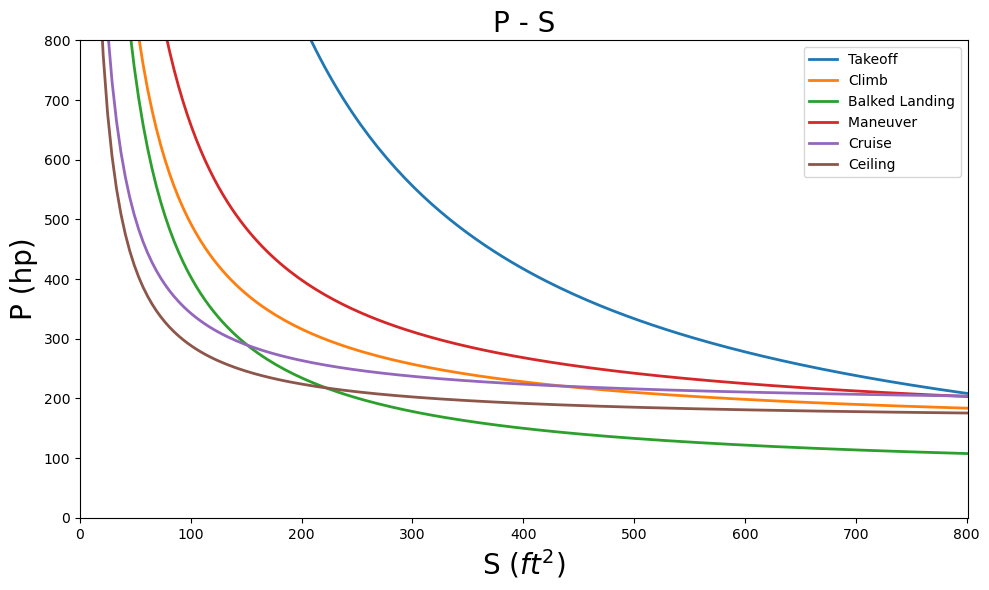

In [390]:
plt.figure(figsize=(10,6))
plt.title('P - S', fontsize=20)
plt.xlabel("S $(ft^2)$", fontsize=20)
plt.ylabel("P (hp)", fontsize=20)
plt.plot(S_range, P_TO, label='Takeoff', linestyle='-', linewidth=2)
plt.plot(S_range, P_CL, label='Climb', linestyle='-', linewidth=2)
plt.plot(S_range, P_BC, label='Balked Landing', linestyle='-', linewidth=2)
plt.plot(S_range, P_MN, label='Maneuver ', linestyle='-', linewidth=2)
plt.plot(S_range, P_CR, label='Cruise', linestyle='-', linewidth=2)
plt.plot(S_range, P_CE, label='Ceiling', linestyle='-', linewidth=2)
plt.ylim(0, 800)
plt.xlim(1,801)
plt.yticks(math.arange(0, 900, step=100))
plt.xticks(math.arange(0, 900, step=100))
plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()
